In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob as gb
import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import models
from tensorflow.keras import optimizers
import json
import cv2
import seaborn as sns
from scipy.stats import norm
import statistics
import random
import shutil
import _utils as fn
%matplotlib inline

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
train_dir = './train4/'
valid_dir = './valid4/'

In [4]:
## Check image amount each folder
trainDir_list = []
for folder in os.listdir(train_dir):
  files = gb.glob('./train4/'+folder+'/')
  for file in files:
    trainDir_list.append(str(file))
    print(folder,':',len(os.listdir(str(file))))

Bacterial_spot : 3050
Early_blight : 3060
healthy : 3048
Septoria_leaf_spot : 3073
Target_Spot : 3075
Tomato_Yellow_Leaf_Curl_Virus : 3060


In [5]:
class_names = os.listdir(train_dir)
print(class_names)

['Bacterial_spot', 'Early_blight', 'healthy', 'Septoria_leaf_spot', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus']


In [6]:
n_classes = len(class_names)
print(n_classes)

6


[3050, 3060, 3048, 3073, 3075, 3060]
max is  3075 
min is  3048


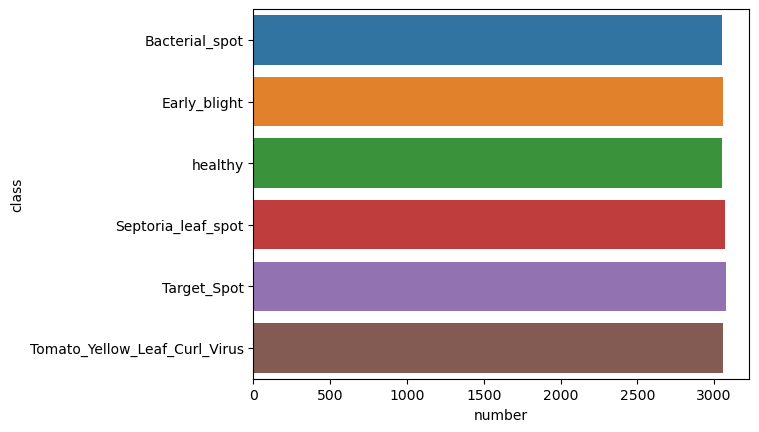

In [7]:
count=[]
for number in class_names :
    count.append(len(os.listdir(train_dir+number)))
print(count)

df = pd.DataFrame({'class':class_names, 'number':count})
g=sns.barplot(data=df,x='number', y='class')

print('max is ',max(count),'\nmin is ',min(count))
# g.set_xticklabels(g.get_xticklabels(), rotation=90) 

[828, 803, 802, 810, 809, 818]
max is  828 
min is  802


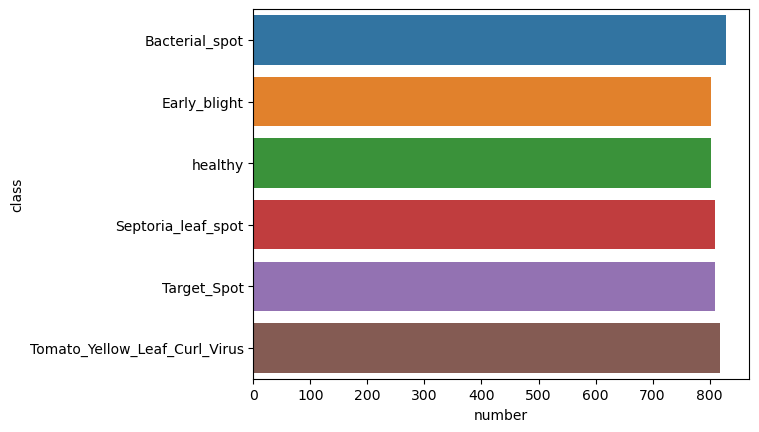

In [8]:
count2=[]
for number in class_names :
    count2.append(len(os.listdir(valid_dir+number)))
print(count2)

df = pd.DataFrame({'class':class_names, 'number':count2})
g=sns.barplot(data=df,x='number', y='class')

print('max is ',max(count2),'\nmin is ',min(count2))
# g.set_xticklabels(g.get_xticklabels(), rotation=90) 

In [9]:
batch_size = 32
img_height = 100
img_width = 100

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle = True,
    color_mode="rgb",
    seed=42,
    subset='training')

validation_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle = True,
    color_mode="rgb",
    seed=42,
    subset='validation')

test_ds = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = False,
    color_mode="rgb",
    seed=42,
    class_mode='sparse')

Found 14694 images belonging to 6 classes.
Found 3672 images belonging to 6 classes.
Found 4870 images belonging to 6 classes.


#### Build Model

In [12]:
target_input = (img_height,img_width,3)

In [13]:
from tensorflow.keras.applications import ResNet50

In [14]:
model = ResNet50(include_top=False, 
                  weights='imagenet',
                  input_shape=target_input)

In [15]:
# for layer in model.layers:
#     layer.trainable = False

In [16]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']      

In [17]:
resnet = models.Sequential()
resnet.add(model)
resnet.add(layers.Flatten())
resnet.add(layers.Dense(512,activation='relu',
                     name='fully_connect_1',
                     kernel_initializer='he_uniform',
                    ))
resnet.add(layers.Dropout(0.5,name='dropout_2'))
resnet.add(layers.Dense(n_classes,activation='softmax',
                     kernel_initializer='he_uniform',
                     name='output'
                    ))
resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 fully_connect_1 (Dense)     (None, 512)               16777728  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 output (Dense)              (None, 6)                 3078      
                                                                 
Total params: 40,368,518
Trainable params: 40,315,398
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 fully_connect_1 (Dense)     (None, 512)               16777728  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 output (Dense)              (None, 6)                 3078      
                                                                 
Total params: 40,368,518
Trainable params: 40,315,398
Non-trainable params: 53,120
_________________________________________________________________


In [19]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=1e-6)
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [20]:
opt = optimizers.Adam(learning_rate=1e-4)
resnet.compile(optimizer=opt,
           loss = 'sparse_categorical_crossentropy',
           metrics=['accuracy'])

In [21]:
history = resnet.fit(
  x=train_ds,
  validation_data=validation_ds,
  epochs=10,
  steps_per_epoch=len(train_ds), 
  validation_steps=len(validation_ds)
)

Epoch 1/10
460/460 [==============================] - 158s 323ms/step - loss: 0.5755 - accuracy: 0.8184 - val_loss: 5.5559 - val_accuracy: 0.1394
Epoch 2/10
460/460 [==============================] - 145s 316ms/step - loss: 0.2117 - accuracy: 0.9260 - val_loss: 1.8654 - val_accuracy: 0.4864
Epoch 3/10
460/460 [==============================] - 145s 315ms/step - loss: 0.1874 - accuracy: 0.9412 - val_loss: 0.1611 - val_accuracy: 0.9428
Epoch 4/10
460/460 [==============================] - 146s 317ms/step - loss: 0.1206 - accuracy: 0.9592 - val_loss: 0.1011 - val_accuracy: 0.9692
Epoch 5/10
460/460 [==============================] - 177s 385ms/step - loss: 0.1003 - accuracy: 0.9655 - val_loss: 0.3784 - val_accuracy: 0.8903
Epoch 6/10
460/460 [==============================] - 144s 312ms/step - loss: 0.1448 - accuracy: 0.9532 - val_loss: 0.1372 - val_accuracy: 0.9589
Epoch 7/10
460/460 [==============================] - 149s 324ms/step - loss: 0.1256 - accuracy: 0.9658 - val_loss: 0.0734 -

In [22]:
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

Last train accuracy: 0.9868654012680054
Last validation accuracy: 0.9645969271659851


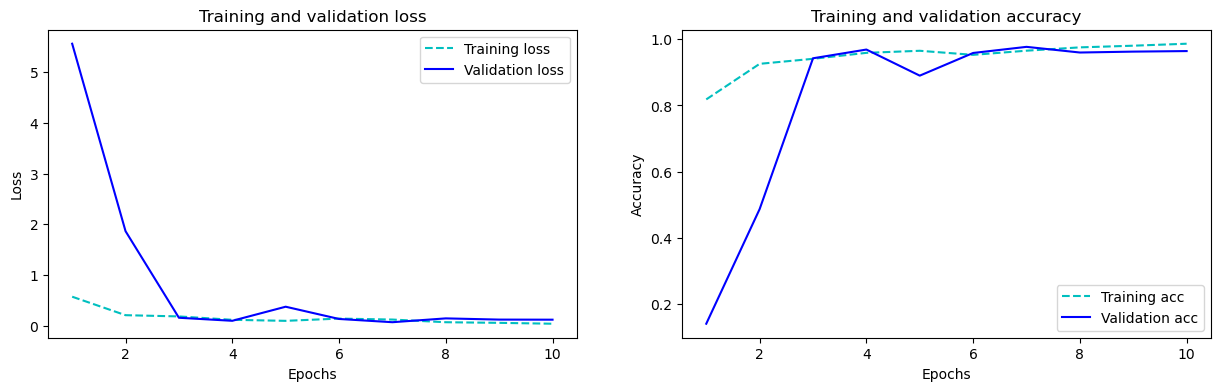

In [23]:
show_result(history)

In [24]:
resnet.evaluate(test_ds)

153/153 [==============================] - 18s 119ms/step - loss: 0.1204 - accuracy: 0.9713


[0.12035901099443436, 0.9712525606155396]

153/153 [==============================] - 18s 118ms/step
Classification Report:
----------------------
                                precision    recall  f1-score   support

               Bacterial_spot       0.96      0.97      0.97       828
                 Early_blight       0.98      0.92      0.95       803
           Septoria_leaf_spot       0.92      0.97      0.94       810
                  Target_Spot       0.98      0.98      0.98       809
Tomato_Yellow_Leaf_Curl_Virus       1.00      0.99      0.99       818
                      healthy       0.99      0.99      0.99       802

                     accuracy                           0.97      4870
                    macro avg       0.97      0.97      0.97      4870
                 weighted avg       0.97      0.97      0.97      4870



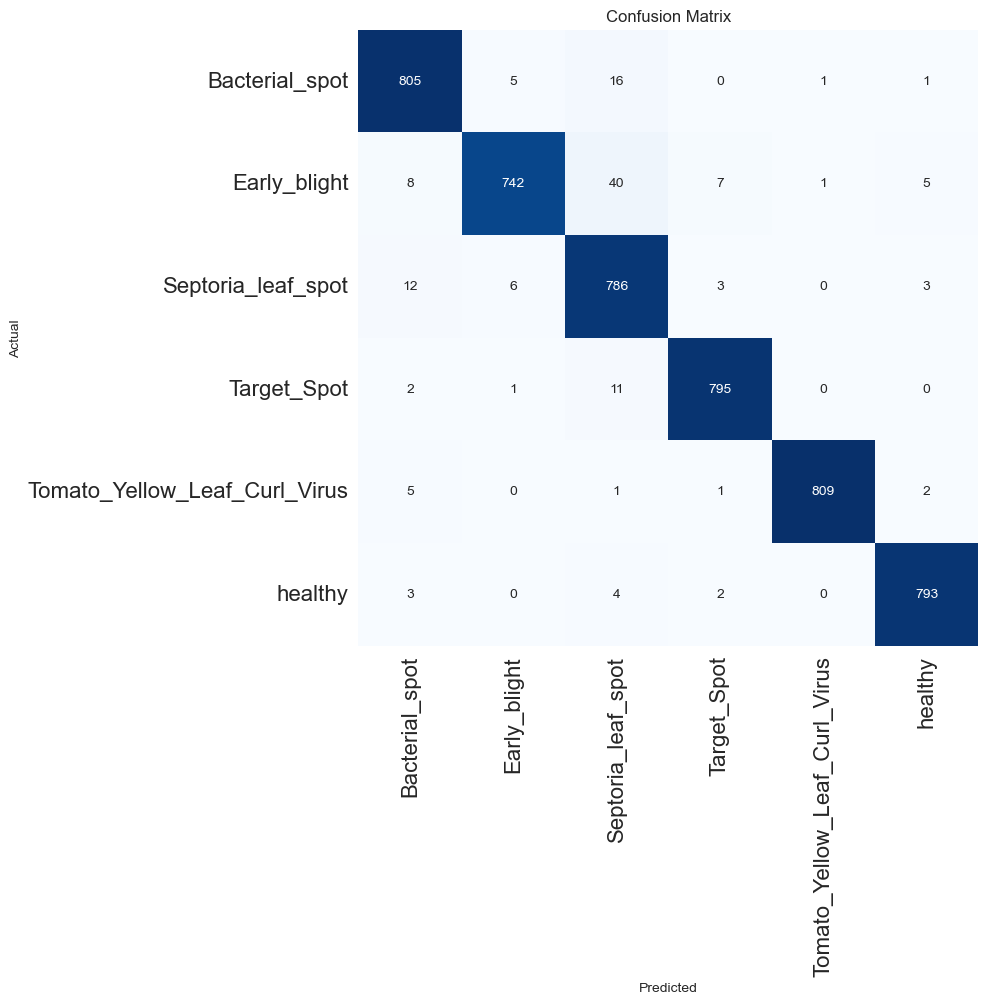

Accuracy: 0.971
Precision: 0.971
Recall: 0.971
F1 Score: 0.971


In [27]:
sns.set_style('darkgrid')
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys()) # ordered lst of class names 
    pred_list=[ ] # will store the predicted classes here
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))
    print('Precision: %.3f' % precision_score(y_true, y_pred, average='micro'))
    print('Recall: %.3f' % recall_score(y_true, y_pred, average='micro'))
    print('F1 Score: %.3f' % f1_score(y_true, y_pred, average='micro'))


cm_cr(test_ds, resnet)

In [26]:
resnet.save('resnet_model.h5')

In [44]:
def predict_disease(image_path):
    img = cv2.imread(image_path)
    resized = cv2.resize(img,(100,100))
    img_array = tf.keras.utils.img_to_array(resized)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = resnet.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    label_names = ['Bacterial spot',
                    'Early blight',
                    'Healthy',
                    'Septoria leaf spot',
                    'Target spot',
                    'Tomato yellow leaf curl_virus']
    label=label_names[np.argmax(score)]
    return label

In [45]:
# Predict single images
img_path = './valid4/healthy/0a0d6a11-ddd6-4dac-8469-d5f65af5afca___RS_HL 0555_180deg.JPG'
print(predict_disease(img_path))

1/1 [==============================] - 0s 53ms/step
Target spot
